# Objective
Investigate identifying which expert annotations for images ISS_rnd0_ch1_z0, ISS_rnd0_ch3_z0, and ISS_rnd1_ch1_z0 correspond with tiny-looking spots, so that we can re-run analysis of the annotations for the RCA pipeline test, but using only expert annotations corresponding with spots that don't look tiny.

# Takeaway

There does not seem to be a strong correlation between spot sigma and intensity - for all images, there are large and small spots across the entire intensity range - so it's unclear which would be a better indicator of whether a spot is tiny-looking.

# Possible next steps

Three possibilities:
1. Use only spots corresponding with the tail (right side of the main mode) of the histogram for spot size.
2. Use only spots corresponding with the tallest bin all the way to the right of the histogram for spot intensity.
3. Redo "expert" annotation – Jenny downloads Rafael's Matlab script and annotates spots that don't look tiny.
 - If it's possible to do this from my laptop, this may be the fastest option.

In [1]:
from math import floor, sqrt
from scipy import ndimage, optimize
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.neighbors import KDTree
from numpy import pi, r_
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math, random, sys, os
sys.path.insert(0, '../../../FISH-annotation/Annotation')
import util
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation

In [2]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 4
max_num_crops = 7
num_partitions = 5
colors = ['red', 'orange', 'black', 'green', 'blue', 'purple', 'cyan']

In [8]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [33]:
coords_dir = '/Users/jenny.vo-phamhi/Documents/fish_annotation_paper/pipeline_testing/RCA/test_images/coords/'
im_dir = '/Users/jenny.vo-phamhi/Documents/fish_annotation_paper/pipeline_testing/RCA/test_images/images/'

filenames = ['ISS_rnd0_ch1_z0', 'ISS_rnd0_ch3_z0', 'ISS_rnd1_ch1_z0']

sigma_max_lists = []
max_intensity_lists = []

for filename in filenames:

    sigma_max_list = []
    max_intensity_list = []
    ref_coords = np.genfromtxt(coords_dir + filename + '.csv', delimiter=',')[1:]
    im = imread(im_dir + filename + '.png')
    im = rgb2gray(im)

    for x, y in ref_coords:

        x_min = int(x)-margin if int(x)-margin >= 0 else 0
        x_max = int(x)+margin if int(x)+margin < im.shape[1] else im.shape[1]-1
        y_min = int(y)-margin if int(y)-margin >= 0 else 0
        y_max = int(y)+margin if int(y)+margin < im.shape[0] else im.shape[0]-1

        crop = im[y_min:y_max, x_min:x_max]
        params = fitgaussian(crop)
        fit = gaussian(*params)
        (height, x_param, y_param, width_x, width_y) = params
        sigma_max = math.sqrt(max(width_x, width_y)/2)
        sigma_max_list.append(sigma_max)
        max_intensity = np.amax(crop)
        max_intensity_list.append(max_intensity)

    sigma_max_lists.append(sigma_max_list)
    max_intensity_lists.append(max_intensity_list)

/usr/local/lib/python3.6/site-packages/scipy/optimize/minpack.py:436: RuntimeWarning: Number of calls to function has reached maxfev = 1200.
  warnings.warn(errors[info][0], RuntimeWarning)


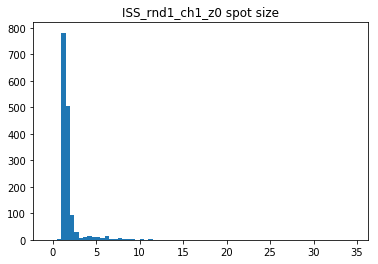

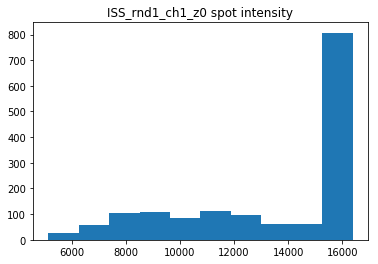

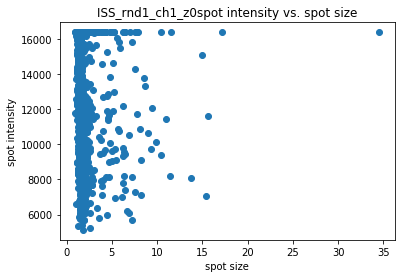

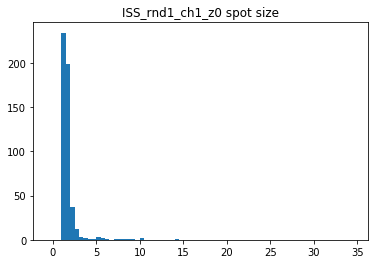

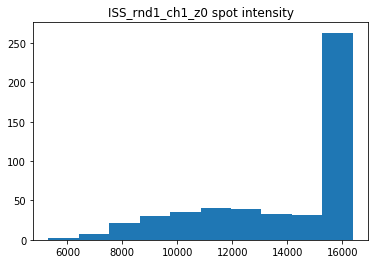

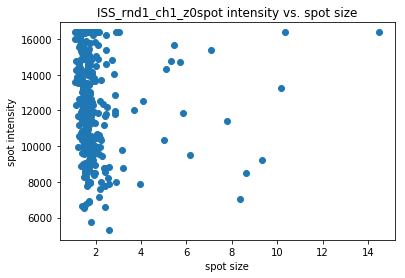

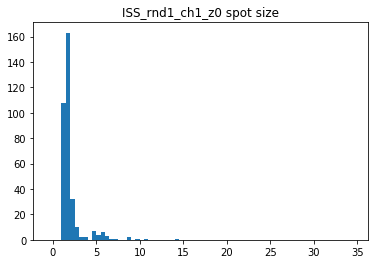

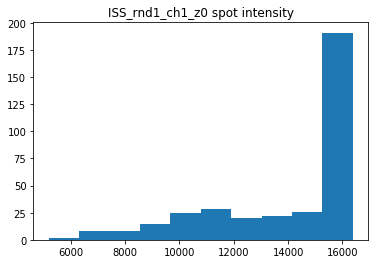

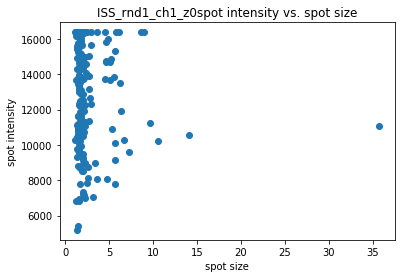

In [42]:
for sigma_max_list, max_intensity_list in zip(sigma_max_lists, max_intensity_lists):
    plt.figure()
    plt.hist(sigma_max_list, bins = np.arange(-0.5, 35, 0.5))
    plt.title(filename + ' spot size')
    plt.show()
    
    plt.figure()
    plt.hist(max_intensity_list)
    plt.title(filename + ' spot intensity')
    plt.show()
    
    plt.figure()
    plt.scatter(sigma_max_list, max_intensity_list)
    plt.title(filename + 'spot intensity vs. spot size')
    plt.xlabel('spot size')
    plt.ylabel('spot intensity')
    plt.show()